# Correlation of various variables on PC1 of North Atlantic SST anomalies

EOFs and PCs are computed in EOF_analysis.ipynb notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cmocean 
from scipy.signal import welch, coherence, cwt
from scipy.signal import detrend as sp_detrend
from scipy import signal
import seaborn as sns
import string
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes


In [2]:
def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

In [3]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")

In [4]:
from dask.distributed import Client, LocalCluster, wait

In [5]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [6]:
client

<Client: 'tcp://127.0.0.1:42023' processes=4 threads=8, memory=59.60 GiB>

## Read PC1 from file

In [7]:
pc1 = xr.open_dataset('data/EOF_PC_10_NAtl_1850-3999.nc', use_cftime=True)['pcs'].sel(mode=0)

## Read NEMO mesh

In [8]:
# Get the NEMO mesh (points to my personal dir, you should change to yours!)
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

In [9]:
# NEMO mesh file has "z" as vertical coordinate
# but the grid_T files have "deptht" so we need to rename
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_tlon = ds_mesh['glamt'].sel(t=0)
da_orca05_tlat = ds_mesh['gphit'].sel(t=0)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_varea = (ds_mesh['e1t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'depthv'})
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_t = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})
da_orca05_mask_v = ds_mesh['vmask'].sel(t=0).rename({'z':'depthv'})

## Read NEMO stream functions

In [10]:
# To read
exp_list = ['FOCI_GJK001','FOCI_GJK006']
#label_list = ['Warm phase','Cold phase']
time_list = [slice('1850-01-01','2850-01-01'), slice('2850-01-01','3950-01-01')]

In [11]:
# NEMO MOC
ds_moc_all = []
ds_mocsig_all = []

for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    
    lat = ds_moc['nav_lat'][0,:,0].data
    ds_moc_lat = ds_moc.assign_coords(lat=("y", lat)) # add latitude to stream functions
    ds_moc_all.append(ds_moc_lat)
    
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOCSIG.nc' % (esmdir,exp,exp)
    print(moc)
    ds_sig = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    
    lat = ds_sig['nav_lat'][0,:,0].data
    ds_sig_lat = ds_sig.assign_coords(lat=("y", lat)) # add latitude to stream functions
    ds_mocsig_all.append(ds_sig_lat)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOCSIG.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*MOCSIG.nc


In [12]:
ds_moc = xr.concat( ds_moc_all, dim='time' )
ds_mocsig = xr.concat( ds_mocsig_all, dim='time' )

In [13]:
ds_mocsig['zomsfglo']

<xarray.DataArray 'zomsfglo' (time: 25200, sigma: 52, y: 511, x: 1)>
dask.array<concatenate, shape=(25200, 52, 511, 1), dtype=float32, chunksize=(120, 52, 511, 1), chunktype=numpy.ndarray>
Coordinates:
  * sigma    (sigma) float32 23.05 23.15 23.25 23.35 ... 27.85 27.95 28.05 28.15
  * time     (time) object 1850-01-16 12:00:00 ... 3949-12-16 12:00:00
    lat      (y) float32 -76.95 -76.84 -76.73 -76.61 ... 89.6 89.79 89.94 89.79
Dimensions without coordinates: y, x
Attributes:
    units:             Sverdrup
    valid_min:         -1000.0
    valid_max:         1000.0
    long_name:         Meridional_Overt.Cell_Global
    short_name:        zomsfglo
    iweight:           1
    online_operation:  N/A
    axis:              TZY
    savelog10:         0.0

## Read NEMO data 

This has been remapped to 2x2 deg grid

In [11]:
# NEMO 3D annual 
ds_oce_1y_all = []

for exp,time in zip(exp_list,time_list):
    oce = '%s/%s/outdata/nemo/1y/r180x90/%s*1y*grid_T.nc' % (esmdir,exp,exp)
    print(oce)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_oce = xr.open_mfdataset(oce,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_oce_1y_all.append(ds_oce)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/1y/r180x90/FOCI_GJK001*1y*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/1y/r180x90/FOCI_GJK006*1y*grid_T.nc


In [12]:
ds_oce_1y = xr.concat( ds_oce_1y_all, dim='time' )

In [13]:
ds_oce_1y

<xarray.Dataset>
Dimensions:            (time: 2100, bnds: 2, lon: 180, lat: 90, deptht: 46)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon                (lon) float64 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * lat                (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * deptht             (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
Dimensions without coordinates: bnds
Data variables: (12/18)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    deptht_bnds        (time, deptht, bnds) float32 dask.array<chunksize=(10, 46, 2), meta=np.ndarray>
    votemper           (time, deptht, lat, lon) float32 dask.array<chunksize=(10, 46, 90, 180), meta=np.ndarray>
    vosaline           (time, deptht, lat, lon) float32 dask.array<chunksize=(10, 46, 90, 180), meta=np.ndarray>
    sosstsst           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    sosaline           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    ...                 ...
    sohefldo           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    hflx_cal           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    somxl010           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    somixhgt           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    sowindsp           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    sobowlin           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Oct 18 20:50:16 2022: cdo -remapbil,r180x90 -setctomiss...
    name:         FOCI_GJK001_1m_18500101_18591231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    timeStamp:    2021-Nov-12 19:21:54 GMT
    uuid:         928b9a2c-960f-4c37-b532-2f9456d34828
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

## Read NEMO derived 

In [17]:
# NEMO heat content remapped to 2deg grid
ds_heatc_all = []

for exp,time in zip(exp_list,time_list):
    heatc = '%s/%s/outdata/nemo/r180x90/%s*1y*heatc.nc' % (esmdir,exp,exp)
    print(heatc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_heatc = xr.open_mfdataset(heatc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_heatc_all.append(ds_heatc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/r180x90/FOCI_GJK001*1y*heatc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/r180x90/FOCI_GJK006*1y*heatc.nc


In [18]:
ds_heatc_1y = xr.concat( ds_heatc_all, dim='time' )

## Read NEMO barotropic streamfunction

In [19]:
# NEMO psi
ds_psi_all = []

for exp,time in zip(exp_list,time_list):
    psi = '%s/%s/outdata/nemo/cdf_analysis/%s*1y*PSI_r360x180.nc' % (esmdir,exp,exp)
    print(psi)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_psi_all.append(ds_psi)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1y*PSI_r360x180.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1y*PSI_r360x180.nc


In [20]:
ds_psi_1y = xr.concat( ds_psi_all, dim='time' )

In [21]:
ds_psi_1y

<xarray.Dataset>
Dimensions:            (time: 2100, bnds: 2, lon: 360, lat: 180)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon                (lon) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(1000, 2), meta=np.ndarray>
    sobarstf           (time, lat, lon) float32 dask.array<chunksize=(1000, 180, 360), meta=np.ndarray>
Attributes:
    CDI:               Climate Data Interface version 1.9.9 (https://mpimet.m...
    Conventions:       CF-1.6
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Thu Dec 08 16:09:49 2022: cdo -v -mergetime -remapbil,...
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....
    frequency:         year
    CDO:               Climate Data Operators version 1.9.9 (https://mpimet.m...

## Read NEMO meridional heat transport

In [22]:
# NEMO vt
ds_vt_all = []

for exp,time in zip(exp_list,time_list):
    vt = '%s/%s/outdata/nemo/cdf_analysis/%s*1y*vT.nc' % (esmdir,exp,exp)
    print(vt)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_vt = xr.open_mfdataset(vt,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    lat = ds_vt['nav_lat'][0,:,0].data
    ds_vt_lat = ds_vt.assign_coords(lat=("y", lat))
    ds_vt_all.append(ds_vt_lat)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1y*vT.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1y*vT.nc


In [23]:
_ds_vt_1y = xr.concat( ds_vt_all, dim='time' )
_ds_vt_1y

<xarray.Dataset>
Dimensions:            (time: 2100, bnds: 2, depthv: 46, y: 511, x: 1)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * depthv             (depthv) float32 3.047 9.454 ... 5.625e+03 5.875e+03
    lat                (y) float32 -76.95 -76.84 -76.73 ... 89.79 89.94 89.79
Dimensions without coordinates: bnds, y, x
Data variables: (12/15)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    nav_lon            (time, y, x) float32 dask.array<chunksize=(10, 511, 1), meta=np.ndarray>
    nav_lat            (time, y, x) float32 dask.array<chunksize=(10, 511, 1), meta=np.ndarray>
    zomht_glo          (time, depthv, y, x) float32 dask.array<chunksize=(10, 46, 511, 1), meta=np.ndarray>
    zomht_atl          (time, depthv, y, x) float32 dask.array<chunksize=(10, 46, 511, 1), meta=np.ndarray>
    zomht_inp          (time, depthv, y, x) float32 dask.array<chunksize=(10, 46, 511, 1), meta=np.ndarray>
    ...                 ...
    zomst_glo          (time, depthv, y, x) float32 dask.array<chunksize=(10, 46, 511, 1), meta=np.ndarray>
    zomst_atl          (time, depthv, y, x) float32 dask.array<chunksize=(10, 46, 511, 1), meta=np.ndarray>
    zomst_inp          (time, depthv, y, x) float32 dask.array<chunksize=(10, 46, 511, 1), meta=np.ndarray>
    zomst_ind          (time, depthv, y, x) float32 dask.array<chunksize=(10, 46, 511, 1), meta=np.ndarray>
    zomst_pac          (time, depthv, y, x) float32 dask.array<chunksize=(10, 46, 511, 1), meta=np.ndarray>
    zomst_inp0         (time, depthv, y, x) float32 dask.array<chunksize=(10, 46, 511, 1), meta=np.ndarray>
Attributes:
    CDI:               Climate Data Interface version 1.9.9 (https://mpimet.m...
    Conventions:       CF-1.6
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    frequency:         year
    history:           Sun Dec 11 20:10:19 2022: cdo -v -yearmean FOCI_GJK001...
    CDO:               Climate Data Operators version 1.9.9 (https://mpimet.m...

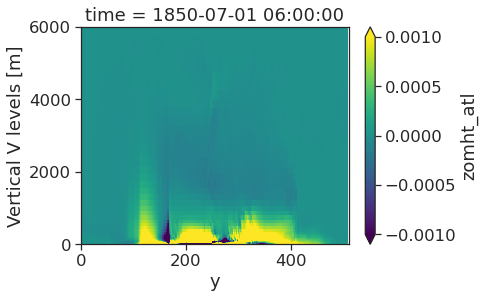

In [24]:
ds_vt_1y = _ds_vt_1y.differentiate('depthv')
ds_vt_1y['zomht_atl'][0,:,:,0].plot(vmin=-1e-3,vmax=1e-3)

## Read OpenIFS annual

In [25]:
# OpenIFS surface
ds_sfc_1y_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_1y_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/1y/*1y*regular_sfc.nc


In [26]:
ds_sfc_1y = xr.concat( ds_sfc_1y_all, dim='time' )

## Compute AMOC time series

In [27]:
# What latitude to use
amoc_lat = 26.5

# Latitudes from NEMO grid
nav_lat = ds_moc_all[0]['nav_lat'][0,:,0].values

# Find j index closest to amoc_lat
amoc_j = np.argmin( np.abs(nav_lat - amoc_lat) )
print(amoc_j, nav_lat[amoc_j])

# Take max stream function at specified latitude
# Then take annual means 
amoc = ds_moc['zomsfatl'].sel(x=0,y=amoc_j).max('depthw').compute()

303 26.279882


In [28]:
ds = amoc.to_dataset()
ds.to_netcdf('data/AMOC26.nc')

In [29]:
amoc = xr.open_dataset('data/AMOC26.nc',use_cftime=True)['zomsfatl']
amoc

<xarray.DataArray 'zomsfatl' (time: 25200)>
array([23.623726, 17.619469, 15.751407, ..., 12.425179, 16.394596, 15.868299],
      dtype=float32)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 3949-12-16 12:00:00
    lat      float32 ...

In [30]:
amoc_anom = amoc - amoc.mean('time')    

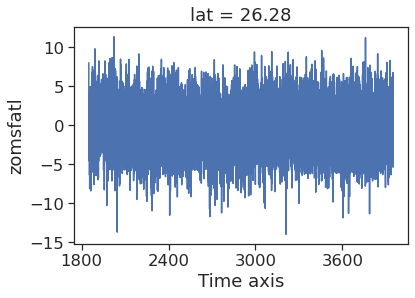

In [31]:
amoc_anom.plot()

## Define phases

In [14]:
label_list = ['Phase1','Phase2','Phase3']
#period_list = [slice('2200-01-01','2500-01-01'), slice('2600-01-01','3200-01-01'), slice('3200-01-01','3500-01-01')]
#period_list_yr = [slice(2200,2500), slice(2600,3199), slice(3200,3500)]

# New updated phases using 20-100 year bandpass
#period_list = [slice('2200-01-01','2550-01-01'), slice('2550-01-01','3300-01-01'), slice('3300-01-01','3550-01-01')]
#period_list_yr = [slice(2200,2550), slice(2550,3300), slice(3300,3500)]

# New definition of phases based on analysing PC1
periods = [ [2000,2450], [2550,3150], [3300,3510] ]
period_list = []
period_list_yr = []
for p in periods:
    period_list.append(slice('%d-01-01' % (p[0],), '%d-01-01' % (p[1],)))
    period_list_yr.append(slice(p[0],p[1]))

## Lagged correlation of AMOC and OpenIFS variables

In [15]:
def lag_corr(x, y, shiftx=0, shifty=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    # Joakim: Assume we correlate AMOC and AMV. If positive AMOC anom
    # precedes positive AMV, then AMOC at year-shift is correlated with AMV at year
    # So correlation at lagx=-5 means x (AMOC) leads y (AMV). 
    if shiftx != 0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = shiftx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if shifty!=0:
        y   = y.shift(time = shifty).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean('time')
    ymean = y.mean('time')
    xstd  = x.std('time')
    ystd  = y.std('time')
    
    #4. Compute covariance along time axis
    cov   =  ((x - xmean)*(y - ymean)).sum('time')/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [16]:
def manylags(x, data, lags):
    
    # Loop over the phases
    if 1:
        
        # List of all correlations
        da_r = []
        da_p = []
        da_k = []
        
        # Loop over lags
        # lag < 0 -> AMOC leads
        # lag > 0 -> AMOC lags
        for lagx in lags:
            
            # Detrend
            xd = detrend(x, dim='time')
            yd = detrend(data, dim='time')
            
            #if lagx == 0:
            #    # Control plot
            #    xd.plot(ax=ax1[jp], label='AMOC')
            #    yd.plot(ax=ax1[jp], label='AMV')
            
            # Linear regression
            _cov, _cor, _k, _m, _p, _std = lag_corr(xd, yd, shiftx=lagx)

            # Add lag as dimension and append to list
            _cor['lag'] = lagx
            _p['lag'] = lagx
            _k['lag'] = lagx
            da_r.append(_cor)
            da_p.append(_p)
            da_k.append(_k)
        
        # Merge along lag dimension
        cor = xr.concat(da_r,dim='lag')
        slope = xr.concat(da_k,dim='lag')
        pval = xr.concat(da_p,dim='lag')
        
    return cor, slope, pval

In [17]:
#x_var = 'AMOC26'
x_var = 'PC1'
#variables = ['AMOC_sig']
#variables = ['H700']
variables = ['SSS','Salt400','MLD','SSH','SST','Temp400']
#variables = ['SST','Qnet','SSS','EP']
#variables = ['MLD','THF','MSL','Precip']
#variables = ['SSR','STR']

run1, run2 = 20,100

slope_list_all = []
cor_list_all = []

for jp in range(0,len(period_list)):
    
    slope_list = []
    cor_list = []
    
    for v in variables:
        
        period = period_list[jp]
        period_yr = period_list_yr[jp]
        label = label_list[jp]
        
        # Running mean
        runmean = 11
        
        if v == 'H700':
            # Heat content at 0-700m
            _da = ds_heatc_1y['voheatc'].sel(depthw=700,method='nearest').fillna(0)
            _da.name = 'h700'
            
        elif v == 'Temp400':
            _da = ds_oce_1y['votemper'].sel(deptht=400,method='nearest').fillna(0)
        
        elif v == 'Salt400':
            _da = ds_oce_1y['vosaline'].sel(deptht=400,method='nearest').fillna(0)
        
        elif v == 'SSS':
            _da = ds_oce_1y['vosaline'].sel(deptht=0,method='nearest').fillna(0)
        
        elif v == 'SSH':
            _da = ds_oce_1y['sossheig'].fillna(0)
            
        elif v == 'MLD':
            _da = ds_oce_1y['somxl010'].fillna(0)
            
        elif v == 'Vtransp360':
            # y=360 is 48N on the ORCA05 grid (approx St Johns to Brest)
            # We multiply by dx * dz to get transport in Sv
            _da = (ds_gridv_1y['vomecrty'] * da_orca05_varea).isel(y=360) * 1e-6
        
        elif v == 'MSL':
            _da = ds_sfc_1y['msl'] * 1e-2 #[hPa]
            
        elif v == 'SST':
            _da = ds_sfc_1y['sstk']
            
        elif v == 'ICE':
            _da = ds_sfc_1y['ci']
            
        elif v == 'THF':
            _da = (ds_sfc_1y['sshf'] + ds_sfc_1y['slhf'])/(6.0*60*60) #[W/m2]
            
        elif v == 'Qnet':
            _da = (ds_sfc_1y['sshf'] + ds_sfc_1y['slhf'] + \
                   ds_sfc_1y['ssr']  + ds_sfc_1y['str'] )/(6.0*60*60) #[W/m2]
        
        elif v == 'SSR':
            _da = (ds_sfc_1y['ssr'])/(6.0*60*60) #[W/m2]
        
        elif v == 'STR':
            _da = (ds_sfc_1y['str'])/(6.0*60*60) #[W/m2]
            
        elif v == 'Precip':
            _da = ds_sfc_1y['tp'] * 4000 #[mm/d]
            
        elif v == 'EP':
            _da = -(ds_sfc_1y['tp'] + ds_sfc_1y['e']) * 4000 #[mm/d]
        
        elif v == 'AMOC':
            _da = ds_moc['zomsfatl'].sel(x=0) # Atlantic overturning in Sv
        
        elif v == 'AMOC_sig':
            _da = ds_mocsig['zomsfatl'].sel(x=0) # Atlantic overturning in Sv
        
        elif v == 'PSI':
            _da = ds_psi_1y['sobarstf'] # barotropic stream function
        elif v == 'heattr':
            _da = ds_vt_1y['zomht_atl']
        elif v == 'salttr':
            _da = ds_vt_1y['zomst_atl']
        
        if x_var == 'AMOC26':
            xx = amoc_anom
        else:
            xx = pc1
        
        # We do time filter first, then select period
        # otherwise we would select a period of 250 years, 
        # then lose 100 years as nans due to filtering
        
        # Bandpass
        _pc1 = xx.groupby('time.year').mean('time').rolling(year=run1,center=True).mean() - \
               xx.groupby('time.year').mean('time').rolling(year=run2,center=True).mean()
        _da1 = _da.groupby('time.year').mean('time').rolling(year=run1,center=True).mean() - \
               _da.groupby('time.year').mean('time').rolling(year=run2,center=True).mean()
    
        # Select period, rename year to time 
        #_pc   = _pc1.sel(year=period_yr).rename({'year':'time'}).dropna('time').compute()
        #_data = _da1.sel(year=period_yr).rename({'year':'time'}).dropna('time').compute()
        
        _pc   = _pc1.sel(year=period_yr).rename({'year':'time'}).fillna(0).compute()
        _data = _da1.sel(year=period_yr).rename({'year':'time'}).fillna(0).compute()
        
        cor, slope, pval = manylags(_pc, _data, lags=[-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30])
        
        cor.name = '%s' % (v,)
        slope.name = '%s' % (v,)
        _ds_cor = cor.to_dataset()
        _ds_slope = slope.to_dataset()
        
        print(cor.name, jp)
        cor_list.append(cor)
        slope_list.append(slope)
    
    cor_list_all.append(cor_list)
    slope_list_all.append(slope_list)

SSH 0
SSH 1
SSH 2


In [18]:
for jp, slope_list in enumerate(slope_list_all):
    for slope in slope_list:
        file = 'data/regression_%s_%s_Phase%d.nc' % (x_var,slope.name, jp+1)
        print(file)
        slope.to_netcdf(file)

data/regression_PC1_SSH_Phase1.nc
data/regression_PC1_SSH_Phase2.nc
data/regression_PC1_SSH_Phase3.nc


KeyError: 'x is not a valid dimension or coordinate'

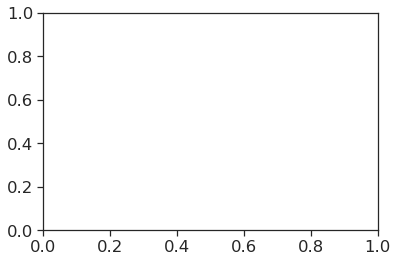

In [37]:
fig, ax = plt.subplots(1,1)
print(slope_list_all[1][0].sel(x=0).sel(lag=-10))
z = slope_list_all[1][0].sel(x=0).sel(lag=-10)
#z.plot.contourf(ax=ax,x='lat',y='depthv',
#                levels=np.linspace(-1e-4, 1e-4, 21))
z.plot.contourf(ax=ax,x='y',y='depthv',
                levels=np.linspace(-1e-6, 1e-6, 21))
ax.set_ylim([0,2000])
ax.set_xlim([-30,85])
ax.invert_yaxis()

## Plot on regular grid 

PC1_SSH_MLD_Salt400_SSS_Phase2_20-100yrbandpass.pdf
data/regression_PC1_SSH_Phase2.nc
SSH
data/regression_PC1_MLD_Phase2.nc
MLD
data/regression_PC1_Salt400_Phase2.nc
Salt400
data/regression_PC1_SSS_Phase2.nc
SSS


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:135: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


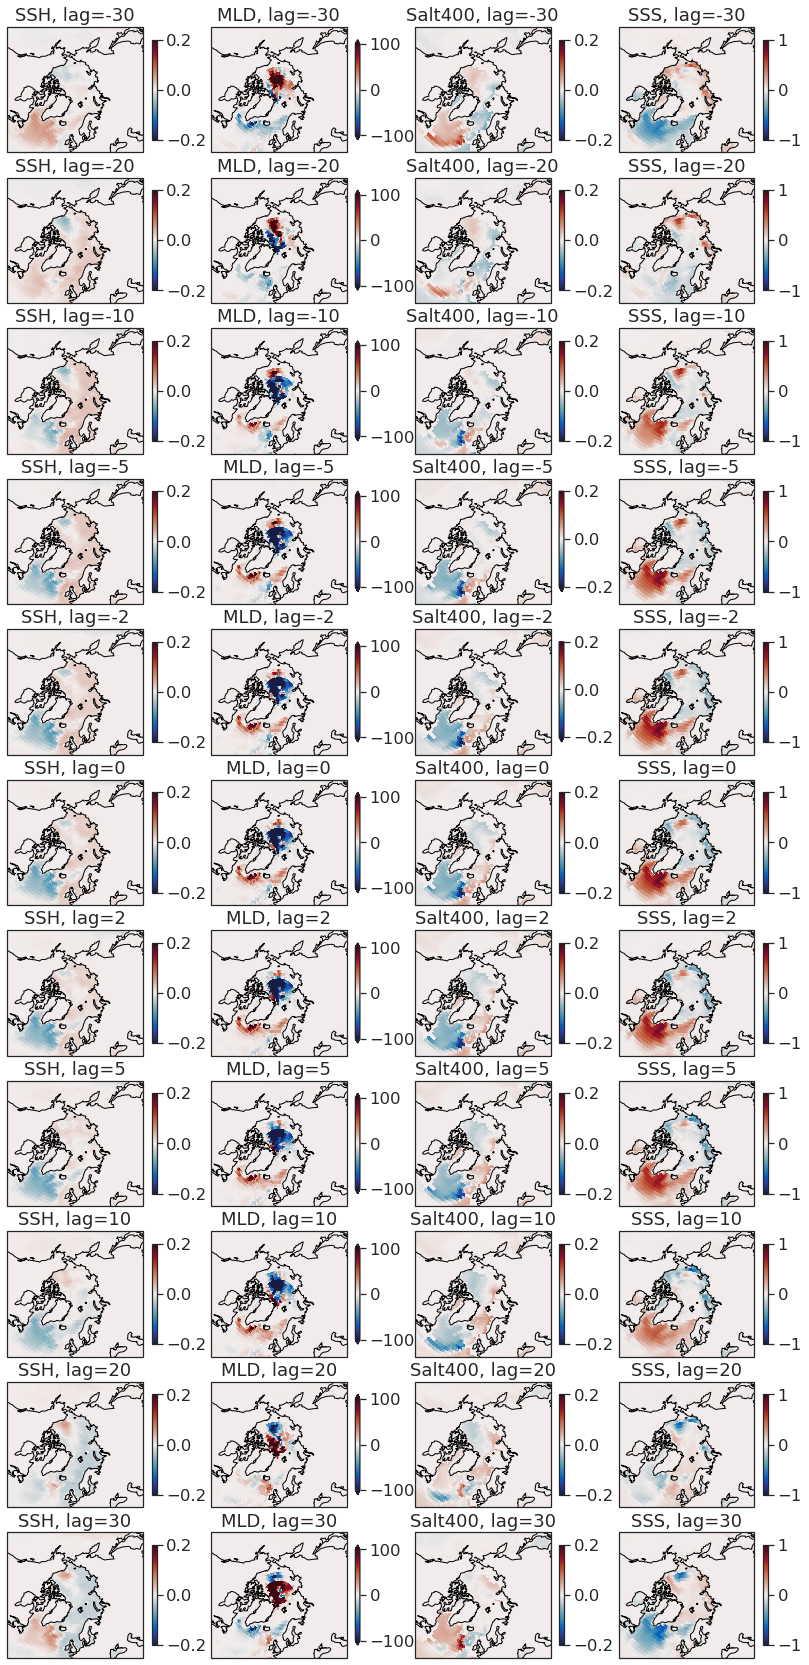

In [38]:
lglobal = False
lnorthpolar = True

if lglobal: 
    glo='_global'
    figsize=(16,30)
else:
    glo=''
    figsize=(14,30)

if lnorthpolar:
    prj = ccrs.NorthPolarStereo()
else:
    prj = ccrs.PlateCarree()
    
fig1, ax1 = plt.subplots(11, 4, figsize=figsize, 
                         subplot_kw={'projection':prj})
lags = [-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30]

#plot_variables = ['SST','SSS','Temp400','Salt400']
#plot_variables = ['SSS','EP','SST','Qnet']
plot_variables = ['SSH','MLD','Salt400','SSS']
#plot_variables = ['H700']
#plot_variables = ['SSR','STR']
#plot_variables = ['MLD','THF','MSL','Precip']

figname = x_var
for pv in plot_variables:
    _tmp = '_%s' % (pv,)
    figname = figname + _tmp

ip = 1
slope_list = slope_list_all[ip]    
figname = figname +'_%s_20-100yrbandpass%s.pdf' % (label_list[ip],glo)
print(figname)

for jv, pv in enumerate( plot_variables ):
    
    #iv = variables.index(pv)
    v = pv #variables[iv]
    
    _f = 'data/regression_%s_%s_Phase%d.nc' % (x_var,pv,ip+1)
    print(_f)
    _ds = xr.open_dataset(_f)
    slope = _ds[pv]
    
    #slope = slope_list[iv]
    
    if v == 'MLD':
        vmin = -100
        vmax = 100
    elif v == 'H700':
        vmin = -1000
        vmax = 1000
    elif v == 'Temp400':
        vmin = -0.5
        vmax = 0.5
    elif v == 'Salt400':
        vmin = -0.2
        vmax = 0.2
    elif v == 'SSS':
        vmin = -1
        vmax = 1
    elif v == 'SSH':
        vmin = -0.2
        vmax = 0.2
    elif v == 'SST':
        vmin = -1
        vmax = 1
    elif v == 'THF':
        vmin = -20
        vmax = 20
    elif v == 'Qnet':
        vmax = 20
        vmin = -vmax
    elif v == 'SSR':
        vmin = -1
        vmax = 1
    elif v == 'STR':
        vmin = -1
        vmax = 1
    elif v == 'MSL':
        vmin = -1
        vmax = 1
    elif v == 'Precip':
        vmin = -0.5
        vmax = 0.5
    elif v == 'EP':
        vmin = -0.5
        vmax = 0.5
    elif v == 'PSI':
        vmax = 2e6
        vmin = -vmax
    elif v == 'ICE':
        vmax = 0.5
        vmin = -0.5
    
    print(pv)
    
    for jl,l in enumerate(lags):
        
        ax = ax1[jl,jv]
        
        # select lag and interpolate to regular grid
        #slope_ll = nemo2ll(slope.sel(lag=l), da_orca05_tlon, da_orca05_tlat)
        
        cbar_kwargs={'shrink':0.8, 'label':''}
        
        #slope_ll.plot(ax=ax, vmin=vmin, vmax=vmax, 
        #              rasterized=True,
        #              cmap=cmocean.cm.balance,
        #              transform=ccrs.PlateCarree())
        slope.sel(lag=l).plot(ax=ax, vmin=vmin, vmax=vmax, 
                      rasterized=True,
                      cmap=cmocean.cm.balance,
                      cbar_kwargs=cbar_kwargs,
                      transform=ccrs.PlateCarree())            
        
        ax.set_title('%s, lag=%d' % (pv,l))
        ax.coastlines()
        if lglobal:
            ax.set_global()
        else:
            ax.set_extent([-100,40,0,90])
        
        ax.set_aspect('auto')
        #ax.set_extent([-180,180,40,90], crs=ccrs.PlateCarree())
        #ax.axhline(y=48.5)
        if lnorthpolar:
            extent = 5000000
            ax.set_extent((-extent, extent,
                           -extent, extent),
                          crs=ccrs.NorthPolarStereo())
        
fig1.tight_layout()
#fig1.savefig('figures/AMOC45_MLD_H700_T400_Phase3_11yrlowpass.pdf',format='pdf')
#fig1.savefig('figures/AMOC26_MLD_T400_S400_SSS_Phase2_20-100yrbandpass.pdf',dpi=150,format='pdf')
fig1.savefig('figures/%s' % (figname,),dpi=150,format='pdf')

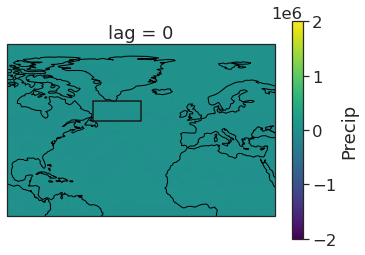

In [38]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()})
slope.sel(lag=0).plot(vmin=-2e6, vmax=2e6, transform=ccrs.PlateCarree())
lon1, lon2 = -55, -30
lat1, lat2 = 50, 60
ax.plot([lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1],'-k')
ax.set_extent([-100,40,0,90])
ax.coastlines()

## Plot T,S for warm and cold periods

PC1_MLD_THF_MSL_Precip_Phase2_20-100yrbandpass_global.pdf


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: FixedFormatter should only be used together with FixedLocator
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator


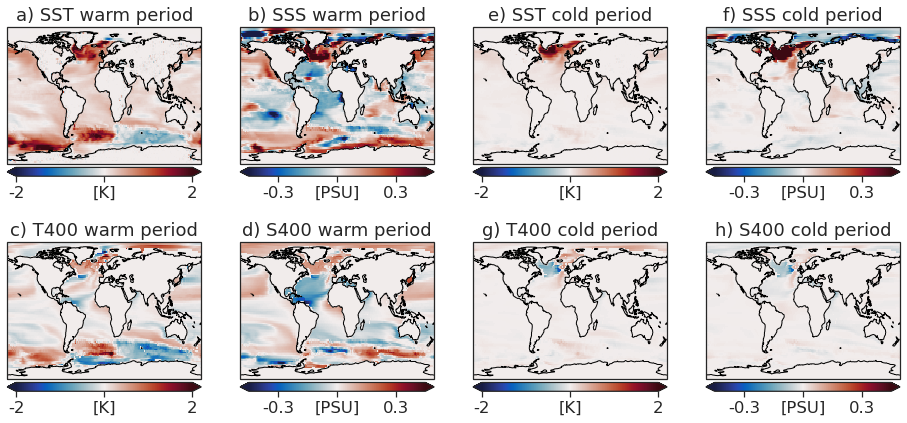

In [48]:
lag = 0
lglobal = True

if lglobal:
    glo = '_global'
else:
    glo = ''

all3=False
if all3:
    figsize=(24,7)
    twoperiods='threeperiods'
    ncols=6
    vp=[0,1,2]
else:
    figsize=(16,7)
    twoperiods='twoperiods'
    ncols=4
    vp=[0,1]
    
fig1, ax1 = plt.subplots(2, ncols, figsize=figsize, 
                         subplot_kw={'projection':ccrs.PlateCarree()})
#fig1 = plt.figure( figsize=(12,5) )
#ax1 = []
#for jr in range(0,2):
#    _ax = []
#    for jc in range(0,4):
#        _ax.append( fig1.add_axes([0.1 + 0.2*jc, 0.9 - 0.3*jr, 0.15, 0.15]) )
    
if 0:
    fig1 = plt.figure( figsize=(12,4) )
    axgr = AxesGrid(fig1, 111, axes_class=axes_class,
                    nrows_ncols=(2, ncols),
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='each',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')
    
figname = 'PC1'
for pv in plot_variables:
    _tmp = '_%s' % (pv,)
    figname = figname + _tmp
    
figname = figname +'_Phase2_20-100yrbandpass%s.pdf' % (glo,)
print(figname)

label_list2 = ['warm period', 'cold period','warm period 2']

letters = string.ascii_lowercase

if 1:
    
    j = 0
    for jp in vp:
        
        cbar_kwargs={'shrink':1, 'orientation':'horizontal', 'pad':0.02, 'extend':'both'}
        _cb_kw = cbar_kwargs.copy()
        
        # Plot SST
        isst = variables.index('SST')
        sst = slope_list_all[jp][isst]
        ax = ax1[0,jp*2]
        vmin, vmax = -2, 2
        p = sst.sel(lag=lag).plot(ax=ax, vmin=vmin, vmax=vmax, 
                              rasterized=True,
                              cmap=cmocean.cm.balance,
                              #cbar_kwargs=_cb_kw,
                              transform=ccrs.PlateCarree(),
                              add_colorbar=False)
        cb = plt.colorbar(p, ax=ax, orientation='horizontal', pad=0.02, extend='both')
        cb.set_ticks = [-2, 0, 2]
        cb.ax.set_xticklabels(['-2', '[K]', '2'])
        ax.set_title('%s) SST %s' % (letters[j], label_list2[jp],))
        j += 1
        
        # Plot SSS
        isss = variables.index('SSS')
        sss = slope_list_all[jp][isss]
        ax = ax1[0,1+jp*2]
        vmin, vmax = -0.3, 0.3
        _cb_kw['label'] = ''
        p = sss.sel(lag=lag).plot(ax=ax, vmin=vmin, vmax=vmax, 
                              rasterized=True,
                              cmap=cmocean.cm.balance,
                              add_colorbar=False,
                              transform=ccrs.PlateCarree()) 
        cb = plt.colorbar(p, ax=ax, orientation='horizontal', pad=0.02, extend='both')
        cb.set_ticks = [-0.3, 0, 0.3]
        cb.ax.set_xticklabels(['-0.3', '[PSU]', '0.3'])
        ax.set_title('%s) SSS %s' % (letters[j],label_list2[jp],))
        j += 1
        
        # Plot Temp400
        it400 = variables.index('Temp400')
        t400 = slope_list_all[jp][it400]
        ax = ax1[1,jp*2]
        vmin, vmax = -2, 2
        #_cb_kw['label'] = '[K]'
        p = t400.sel(lag=lag).plot(ax=ax, vmin=vmin, vmax=vmax, 
                               rasterized=True,
                               cmap=cmocean.cm.balance,
                               #cbar_kwargs=_cb_kw,
                               add_colorbar=False,
                               transform=ccrs.PlateCarree()) 
        cb = plt.colorbar(p, ax=ax, orientation='horizontal', pad=0.02, extend='both')
        cb.set_ticks = [-2, 0, 2]
        cb.ax.set_xticklabels(['-2', '[K]', '2'])
        ax.set_title('%s) T400 %s' % (letters[j],label_list2[jp],))
        j += 1
        
        # Plot Salt400
        is400 = variables.index('Salt400')
        s400 = slope_list_all[jp][is400]
        ax = ax1[1,1+jp*2]
        vmin, vmax = -0.3, 0.3
        #_cb_kw['label'] = '[PSU]'
        p = s400.sel(lag=lag).plot(ax=ax, vmin=vmin, vmax=vmax, 
                               rasterized=True,
                               cmap=cmocean.cm.balance,
                               #cbar_kwargs=_cb_kw,
                               add_colorbar=False,
                               transform=ccrs.PlateCarree()) 
        cb = plt.colorbar(p, ax=ax, orientation='horizontal', pad=0.02, extend='both')
        cb.set_ticks = [-0.3, 0, 0.3]
        cb.ax.set_xticklabels(['-0.3', '[PSU]', '0.3'])
        ax.set_title('%s) S400 %s' % (letters[j],label_list2[jp],))
        j += 1
        
for ax in ax1.flat:
    ax.coastlines()
    if lglobal:
        ax.set_global()
    else:
        ax.set_extent([-100,40,0,90])
    ax.set_aspect('auto')
    
    
fig1.subplots_adjust(hspace=0.3)
fig1.savefig('figures/Fig_SST_SSS_T400_S400_%s.pdf' % (twoperiods,),dpi=150,format='pdf')

## Plot AMOC regression

AMOC26_salttr_AllPhases_20-100yrbandpass.pdf
data/regression_AMOC26_salttr_Phase1.nc
salttr
data/regression_AMOC26_salttr_Phase2.nc
salttr
data/regression_AMOC26_salttr_Phase3.nc
salttr


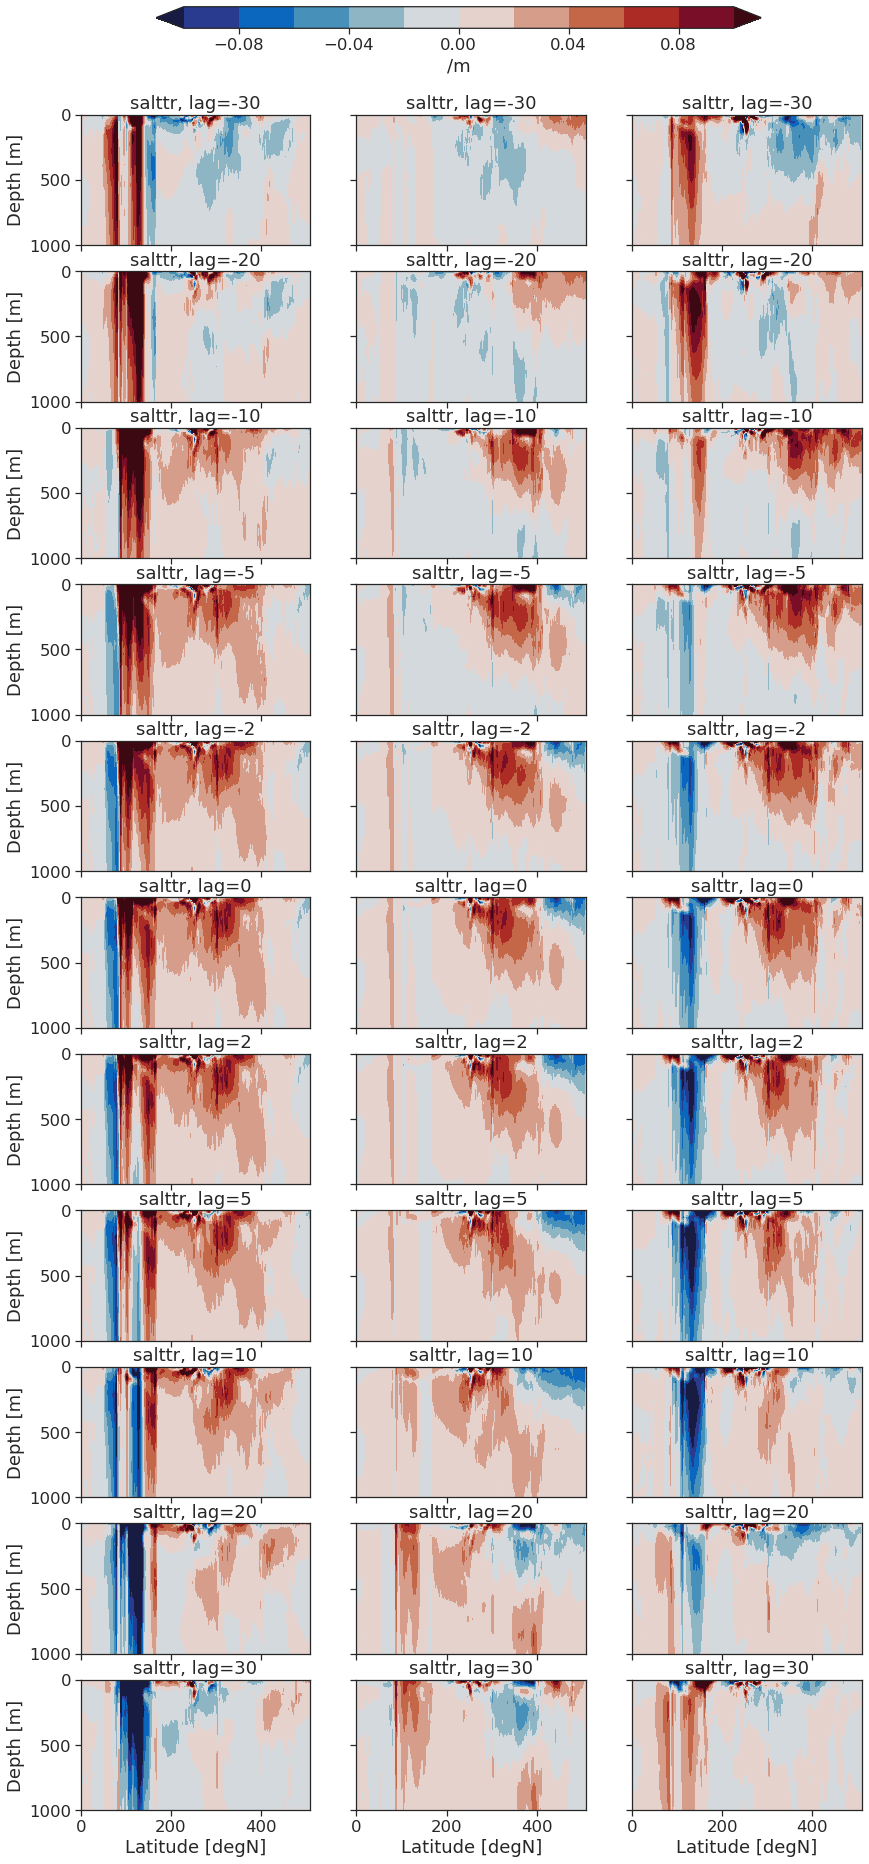

In [54]:
fig1, ax1 = plt.subplots(11, 3, figsize=(14,30))
fig1.subplots_adjust(top=0.91)
cb_ax = fig1.add_axes([0.2, 0.95, 0.6, 0.01])

#fig1 = plt.figure( 1, (10, 25) )
#ax1 = AxesGrid(fig1, 111,
#                nrows_ncols=(11, 3),
#                axes_pad=0.05,
#                cbar_location='top',
#                cbar_mode='single',
#                cbar_pad=0.1,
#                cbar_size='3%',
#                label_mode='L',
#               share_all=True,
#               aspect=False,
#              direction='column')

lags = [-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30]

plot_variables = ['salttr']

figname = '%s' % (x_var,)
for pv in plot_variables:
    _tmp = '_%s' % (pv,)
    figname = figname + _tmp
    
figname = figname +'_AllPhases_20-100yrbandpass.pdf'
print(figname)

ja = 0

for jp, slope_list in enumerate(slope_list_all):
    for jv, pv in enumerate( plot_variables ):
        
        #iv = variables.index(pv)
        #v = variables[iv]
        ip = jp+1
        _f = 'data/regression_%s_%s_Phase%d.nc' % (x_var,pv,ip)
        print(_f)
        _ds = xr.open_dataset(_f)
        slope = _ds[pv]
        
        #slope = slope_list[iv]
        
        ymin, ymax = 0, 1000
        
        if pv == 'AMOC':
            vmin = -2
            vmax = 2
            x = 'lat'
            y = 'depthw'
            _slope = slope.sortby('lat')
        
        elif pv == 'AMOC_sig':
            vmin = -2
            vmax = 2
            x = 'lat'
            y = 'sigma'
            _slope = slope.sortby('lat')
            ymin, ymax = 23, 28
        
        elif pv == 'heattr':
            unit = 'TW/m'
            vmax = 0.3
            vmin = -vmax
            x = 'y'
            y = 'depthv'
            _slope = slope.sortby(x).sel(x=0) * 1e3
            
        elif pv == 'salttr':
            unit = '/m'
            vmax = 0.1
            vmin = -vmax
            x = 'y'
            y = 'depthv'
            _slope = slope.sortby(x).sel(x=0) 
            
        else:
            x = 'x'
            y = 'y'
            _slope = slope
        
        print(pv)
        for jl,l in enumerate(lags):
            
            #ax = ax1[ja]
            ax = ax1[jl,jp]
            cbar_kwargs={'label':unit, 'orientation':'horizontal'}
            
            #_slope.sel(lag=l).plot(ax=ax, x='lat', y='depthw',
            #                       vmin=vmin, vmax=vmax, 
            #                       rasterized=True,
            #                       cmap=cmocean.cm.balance,
            #                       cbar_kwargs=cbar_kwargs)
            _z = _slope.sel(lag=l)
            if ja == 0:
                kw = {'cbar_ax':cb_ax, 'add_colorbar':True, 'cbar_kwargs':cbar_kwargs}
            else:
                kw = {'add_colorbar':False}
                
            _z.plot.contourf(ax=ax, x=x, y=y,
                             levels=np.linspace(vmin,vmax,11),
                             cmap=cmocean.cm.balance,
                             **kw)
            #ax.contourf(_z[x].data, _z[y].data, _z.data,
            #            levels=np.linspace(vmin,vmax,11),
            #            cmap=cmocean.cm.balance)
            
            ax.set_title('%s, lag=%d' % (pv,l))
            
            #if v == 'AMOC':
            #ax.set_xlim([-30,88])
            ax.set_ylim([ymin,ymax])
            #ax.set_extent([-180,180,40,90], crs=ccrs.PlateCarree())
            #ax.axhline(y=48.5)
            ax.invert_yaxis()
            
            if jp == 0:
                ax.set_ylabel('Depth [m]')
            else:
                ax.set_ylabel('')
                ax.set_yticklabels([])
                
            if jl == len(lags)-1:
                ax.set_xlabel('Latitude [degN]')
            else:
                ax.set_xlabel('')
                ax.set_xticklabels([])
            
            ja=ja+1
        
#fig1.tight_layout()
fig1.savefig('figures/%s' % (figname,),dpi=150,format='pdf')

## Regress variables on PC1 of North Atlantic MSLP (NAO)

In [17]:
## Read NAO PC
_ds = xr.open_dataset('data/EOF_PC_1_NAO_1850-3999.nc')

eof1_nao = _ds['eofs']
pc1_nao = _ds['pcs']

pc1_nao

<xarray.DataArray 'pcs' (year: 2099)>
array([ 2.609235,  0.552959,  0.720032, ..., -0.496531,  0.269009, -0.852696],
      dtype=float32)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 3944 3945 3946 3947 3948

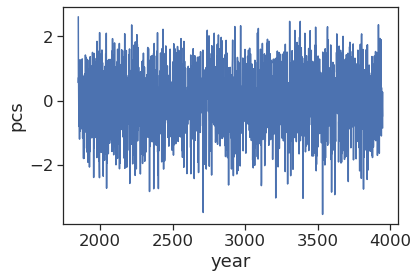

In [57]:
pc1_nao.plot()

In [94]:
variables = ['MSL','PSI','THF','ICE','curl']
#variables = ['curl']

slope_list_all = []
cor_list_all = []

for jp in range(0,len(period_list)):
    
    slope_list = []
    cor_list = []
    
    for v in variables:
        
        period = period_list[jp]
        period_yr = period_list_yr[jp]
        label = label_list[jp]
        
        # Running mean
        runmean = 11
        
        if v == 'H700':
            # Heat content at 0-700m
            _da = ds_heatc_1m['voheatc'].sel(depthw=700,method='nearest').fillna(0)
            _da.name = 'h700'
            
        elif v == 'Temp400':
            _da = ds_oce_1y['votemper'].sel(deptht=400,method='nearest').fillna(0)
        
        elif v == 'Salt400':
            _da = ds_oce_1y['vosaline'].sel(deptht=400,method='nearest').fillna(0)
        
        elif v == 'SSS':
            _da = ds_oce_1y['vosaline'].sel(deptht=0,method='nearest').fillna(0)
            
        elif v == 'MLD':
            _da = ds_oce_1y['somxl010'].fillna(0)
            
        elif v == 'Vtransp360':
            # y=360 is 48N on the ORCA05 grid (approx St Johns to Brest)
            # We multiply by dx * dz to get transport in Sv
            _da = (ds_gridv_1y['vomecrty'] * da_orca05_varea).isel(y=360) * 1e-6
        
        elif v == 'MSL':
            _da = ds_sfc_1y['msl'] * 1e-2 #[hPa]
            
        elif v == 'SST':
            _da = ds_sfc_1y['sstk']
            
        elif v == 'ICE':
            _da = ds_sfc_1y['ci'] # ice fraction
            
        elif v == 'THF':
            _da = (ds_sfc_1y['sshf'] + ds_sfc_1y['slhf'])/(6.0*60*60) #[W/m2]
        
        elif v == 'SSR':
            _da = (ds_sfc_1y['ssr'])/(6.0*60*60) #[W/m2]
        
        elif v == 'STR':
            _da = (ds_sfc_1y['str'])/(6.0*60*60) #[W/m2]
            
        elif v == 'Precip':
            _da = ds_sfc_1y['tp'] * 4000 #[mm/d]
        
        elif v == 'AMOC':
            _da = ds_moc['zomsfatl'].sel(x=0) # Atlantic overturning in Sv
        
        elif v == 'PSI':
            _da = ds_psi_1y['sobarstf'] # barotropic stream function
            
        elif v == 'curl':
            # stress is N/m2*s. Divide by seconds to get N/m2. 
            scale = 180./(np.pi * 6371e3) # scale d/dphi -> d/dy
            # d/dy(tau_x) - d/dx(tau_y) 
            # centered differences
            taux_y = ds_sfc_1y['ewss'].differentiate('lat') * scale # dtaux/dy 
            tauy_x = ds_sfc_1y['nsss'].differentiate('lon') * scale * np.cos( np.deg2rad(ds_sfc['lat']) ) # dtauy/dx 
            _da = (taux_y - tauy_x) / (6.0*60*60) #[N/m3]

        print(_da)
        
        # We do time filter first, then select period
        # otherwise we would select a period of 250 years, 
        # then lose 100 years as nans due to filtering
        
        # Bandpass
        run1, run2 = 20,100
        _pc1 = pc1_nao.rolling(year=run1,center=True).mean() - \
               pc1_nao.rolling(year=run2,center=True).mean()
        _da1 = _da.groupby('time.year').mean('time').rolling(year=run1,center=True).mean() - \
               _da.groupby('time.year').mean('time').rolling(year=run2,center=True).mean()
        
        # Select period, rename year to time 
        _pc   = _pc1.sel(year=period_yr).rename({'year':'time'}).fillna(0).compute()
        _data = _da1.sel(year=period_yr).rename({'year':'time'}).fillna(0).compute()
        
        cor, slope, pval = manylags(_pc, _data, lags=[-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30])
        
        cor.name = '%s' % (v,)
        slope.name = '%s' % (v,)
        _ds_cor = cor.to_dataset()
        _ds_slope = slope.to_dataset()
        
        print(cor.name, jp)
        cor_list.append(cor)
        slope_list.append(slope)
    
    cor_list_all.append(cor_list)
    slope_list_all.append(slope_list)

<xarray.DataArray 'msl' (time: 2100, lat: 96, lon: 192)>
dask.array<mul, shape=(2100, 96, 192), dtype=float32, chunksize=(10, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06
MSL 0
<xarray.DataArray 'sobarstf' (time: 2100, lat: 180, lon: 360)>
dask.array<concatenate, shape=(2100, 180, 360), dtype=float32, chunksize=(1100, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:         Barotropic_Stream_Function
    units:             m3/s
    cell_methods:      time_counter: mean
    short_name:        sobarstf
   

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


curl 1
<xarray.DataArray 'msl' (time: 2100, lat: 96, lon: 192)>
dask.array<mul, shape=(2100, 96, 192), dtype=float32, chunksize=(10, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06
MSL 2
<xarray.DataArray 'sobarstf' (time: 2100, lat: 180, lon: 360)>
dask.array<concatenate, shape=(2100, 180, 360), dtype=float32, chunksize=(1100, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:         Barotropic_Stream_Function
    units:             m3/s
    cell_methods:      time_counter: mean
    short_name:        sobar

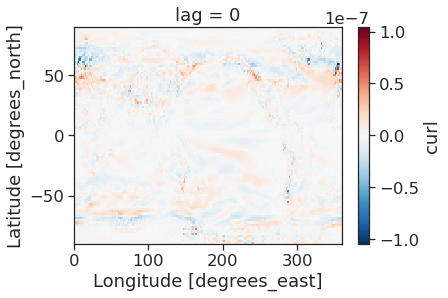

In [84]:
slope_list_all[0][4].sel(lag=0).plot()

PC1_NAO_MSL_curl_PSI_THF_Phase2_20-100yrbandpass.pdf
MSL
curl
PSI
THF


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


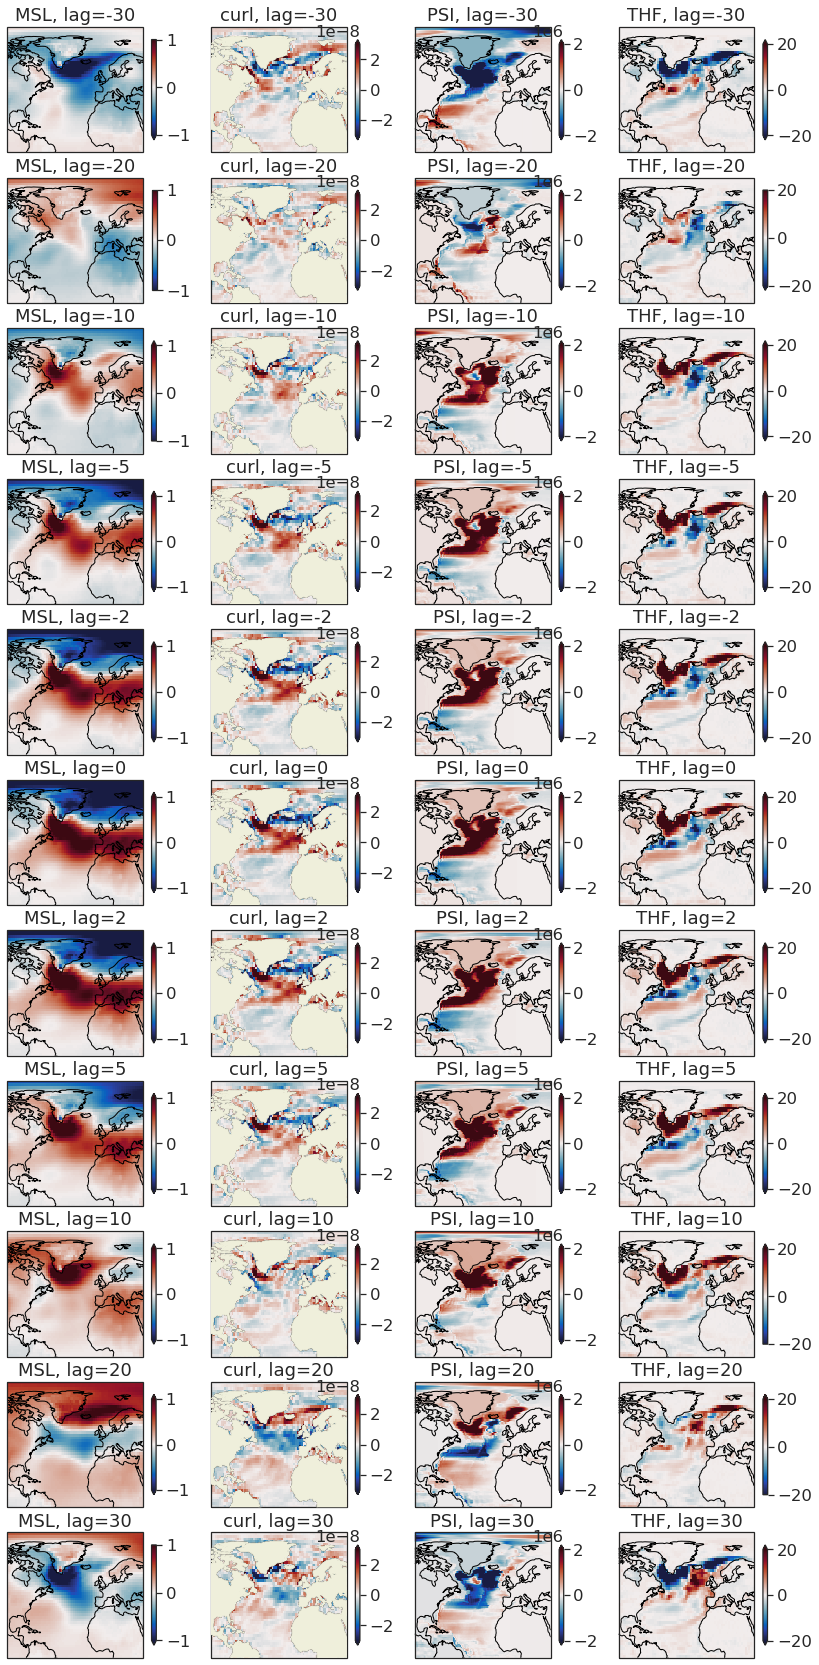

In [101]:
lglobal = False
if lglobal: 
    glo='_global'
    figsize=(16,30)
else:
    glo=''
    figsize=(14,30)

fig1, ax1 = plt.subplots(11, 4, figsize=figsize, 
                         subplot_kw={'projection':ccrs.PlateCarree()})
lags = [-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30]

#plot_variables = ['MSL','curl','PSI','ICE'] 
plot_variables = ['MSL','curl','PSI','THF'] 
#plot_variables = ['MLD','THF','MSL','Precip']
#plot_variables = ['SSR','STR']

figname = 'PC1_NAO'
for pv in plot_variables:
    _tmp = '_%s' % (pv,)
    figname = figname + _tmp

ip = 1
slope_list = slope_list_all[ip]    
figname = figname +'_%s_20-100yrbandpass%s.pdf' % (label_list[ip],glo)
print(figname)

for jv, pv in enumerate( plot_variables ):
    
    iv = variables.index(pv)
    v = variables[iv]
    
    slope = slope_list[iv]
    
    if v == 'MLD':
        vmin = -100
        vmax =  100
    elif v == 'H700':
        vmin = -1000
        vmax = 1000
    elif v == 'Temp400':
        vmin = -0.1
        vmax = 0.1
    elif v == 'Salt400':
        vmin = -0.02
        vmax = 0.02
    elif v == 'SSS':
        vmin = -0.03
        vmax = 0.03
    elif v == 'SST':
        vmin = -1
        vmax = 1
    elif v == 'THF':
        vmin = -20
        vmax = 20
    elif v == 'SSR':
        vmin = -1
        vmax = 1
    elif v == 'STR':
        vmin = -1
        vmax = 1
    elif v == 'MSL':
        vmin = -1
        vmax = 1
    elif v == 'Precip':
        vmin = -0.5
        vmax = 0.5
    elif v == 'curl':
        vmax = 3e-8
        vmin = -vmax
    elif v == 'PSI':
        vmax = 2e6
        vmin = -vmax
    elif v == 'ICE':
        vmax = 0.5
        vmin = -vmax
    
    print(v)
    for jl,l in enumerate(lags):
        
        ax = ax1[jl,jv]
        
        # select lag and interpolate to regular grid
        #slope_ll = nemo2ll(slope.sel(lag=l), da_orca05_tlon, da_orca05_tlat)
        
        cbar_kwargs={'shrink':0.8, 'label':''}
        
        #slope_ll.plot(ax=ax, vmin=vmin, vmax=vmax, 
        #              rasterized=True,
        #              cmap=cmocean.cm.balance,
        #              transform=ccrs.PlateCarree())
        slope.sel(lag=l).plot(ax=ax, vmin=vmin, vmax=vmax, 
                      rasterized=True,
                      cmap=cmocean.cm.balance,
                      cbar_kwargs=cbar_kwargs,
                      transform=ccrs.PlateCarree())            
        
        ax.set_title('%s, lag=%d' % (v,l))
        ax.coastlines()
        if v == 'curl':
            ax.add_feature(cfeature.LAND, zorder=100)
        
        if lglobal:
            ax.set_global()
        else:
            ax.set_extent([-100,40,0,90])
        
        ax.set_aspect('auto')
        #ax.set_extent([-180,180,40,90], crs=ccrs.PlateCarree())
        #ax.axhline(y=48.5)
        
fig1.tight_layout()
#fig1.savefig('figures/AMOC45_MLD_H700_T400_Phase3_11yrlowpass.pdf',format='pdf')
#fig1.savefig('figures/AMOC26_MLD_T400_S400_SSS_Phase2_20-100yrbandpass.pdf',dpi=150,format='pdf')
fig1.savefig('figures/%s' % (figname,),dpi=150,format='pdf')

<xarray.Dataset>
Dimensions:            (time: 1100, bnds: 2, lon: 192, lat: 96)
Coordinates:
  * time               (time) object 2850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon                (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * lat                (lat) float32 -89.06 -87.19 -85.31 ... 85.31 87.19 89.06
Dimensions without coordinates: bnds
Data variables: (12/42)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    sstk               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ci                 (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    es                 (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    tclw               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    tciw               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ...                 ...
    swvl1              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl2              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl3              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl4              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    sro                (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ssro               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         ECE3_1m_28500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2022-Jul-12 18:22:59 GMT
    uuid:         f9691f0c-d60a-48b1-b512-6d180467f3c5
    history:      Wed Aug 24 14:53:18 2022: ncks -O -7 --no-alphabetize -L 1 ...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

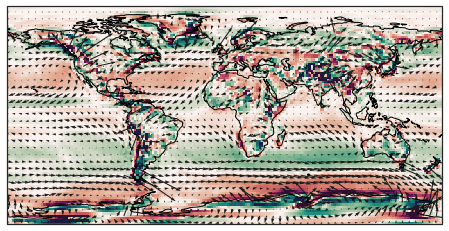

In [73]:
fig, ax  = plt.subplots(1,1,figsize=(12,4),subplot_kw={'projection':ccrs.PlateCarree()})

taux = ds_sfc['ewss'].isel(time=0)
tauy = ds_sfc['nsss'].isel(time=0)

scale = 180./(np.pi * 6371e3)
taux_y = taux.differentiate('lat') * scale # dtaux/dy 
tauy_x = tauy.differentiate('lon') * scale * np.cos( np.deg2rad(ds_sfc['lat']) ) # dtauy/dx 
curl = (taux_y - tauy_x).compute()

vmax = 1e-2
ax.pcolormesh(ds_sfc['lon'], ds_sfc['lat'], curl, vmin=-vmax, vmax=vmax, cmap=cmocean.cm.curl)

stride=3
ax.quiver(ds_sfc['lon'][::stride], ds_sfc['lat'][::stride],
          taux[::stride, ::stride], tauy[::stride, ::stride],
          transform=ccrs.PlateCarree())


ax.coastlines()

ds_sfc